In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from pathlib import Path
from IPython.display import display
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
from sklearn.model_selection import train_test_split
from causallift import CausalLift
#from matplotlib import ticker
sns.set()

In [2]:
#set path
p = Path.cwd() / 'practical'
#load data and covert timestamps
unix_ts = partial(pd.to_datetime, unit='s')

email_data = pd.read_csv(p/'email_data.csv', parse_dates=['event_time'], 
                       date_parser=unix_ts)
orders = pd.read_csv(p/'orders.csv', parse_dates=['event_time'],
                        date_parser=unix_ts)
params = pd.read_csv(p/'params.csv', parse_dates=['first_order_date','last_order_date'], 
                       date_parser=unix_ts)

In [3]:
###Review data info
# display(email_data.head())
# display(orders.head())
# display(params.head())
print('Email data');email_data.info(); print('\n Orders'); orders.info(); print('\nParams'); params.info()



Email data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375626 entries, 0 to 375625
Data columns (total 3 columns):
id            375626 non-null object
event_time    375626 non-null datetime64[ns]
event_type    375626 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 8.6+ MB

 Orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44193 entries, 0 to 44192
Data columns (total 5 columns):
product       44193 non-null object
event_type    44193 non-null object
event_time    44193 non-null datetime64[ns]
id            44193 non-null object
revenue       44193 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.7+ MB

Params
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307992 entries, 0 to 1307991
Data columns (total 8 columns):
id                       1307992 non-null object
has_purchased_widget     512207 non-null object
has_purchased_trinket    512207 non-null object
has_purchased_gizmo      512207 non-null object
order_count    

In [4]:
####Compare date range across data-sets
print(f'Email data\nbegin: {email_data["event_time"].min()}, end: {email_data["event_time"].max()}')
print(f'Orders\nbegin: {orders["event_time"].min()}, end: {orders["event_time"].max()}')
print(f'Params\nfirst order: {params["first_order_date"].min()}, last order: {params["last_order_date"].max()}')
#email_data.describe()
####campaign spans from April 25th through May 21st 2017


Email data
begin: 2017-04-25 19:00:51, end: 2017-05-21 23:56:04
Orders
begin: 2017-04-22 00:00:27, end: 2017-05-21 23:58:50
Params
first order: 2014-04-22 00:00:00, last order: 2017-08-03 00:00:00


In [5]:
####EMAIL
### generate snapshot of EMAIL data characteristics
display(email_data.describe())
display(email_data.head())

id           event_time  event_type
count                                 375626               375626      375626
unique                                265736                48534           3
top     b4fe117c-c124-4445-a847-0fca26398002  2017-04-25 19:17:39  email_send
freq                                     921                12002      265737
first                                    NaN  2017-04-25 19:00:51         NaN
last                                     NaN  2017-05-21 23:56:04         NaN

id          event_time  event_type
0  0d170fdf-fc33-43be-9a62-c9b644525cf5 2017-04-25 19:00:51  email_send
1  1b44fece-d7dd-44f5-9ee9-a4ffe6999c70 2017-04-25 19:17:38  email_send
2  3f2e34a5-630c-4859-8677-39f5b07050f2 2017-04-25 19:17:38  email_send
3  125499e4-1986-4722-b9e5-e89e56443c41 2017-04-25 19:17:38  email_send
4  d7ee18ee-0155-463a-93c8-70eba7bcdf50 2017-04-25 19:17:38  email_send

In [6]:
###confirm categories of email dataset
print(email_data["event_type"].unique())
email_data.isna().any()

['email_send' 'email_open' 'email_click']


id            False
event_time    False
event_type    False
dtype: bool

In [7]:
###create a table to view counts across email categories
e_tmp = email_data.groupby(['event_time','event_type']).count().unstack()
e_tmp.head()

id                      
event_type          email_click email_open email_send
event_time                                           
2017-04-25 19:00:51         NaN        NaN        1.0
2017-04-25 19:01:01         NaN        1.0        NaN
2017-04-25 19:01:31         NaN        1.0        NaN
2017-04-25 19:02:14         NaN        1.0        NaN
2017-04-25 19:03:27         NaN        2.0        NaN

The graph below plots the 30 minute rolling average of emails opened, sent and clicked. The open and click rates are
highest in the hours after the promotion was sent.  

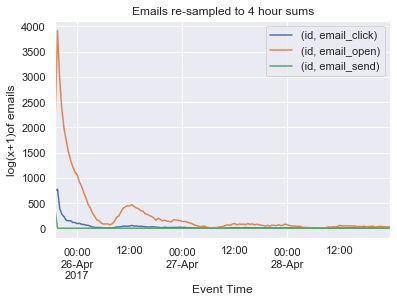

In [8]:
###
ax = e_tmp.applymap(lambda x: np.log1p(x))[:'2017-04-28'].resample('.5H').sum().plot()
ax.set_title("Emails re-sampled to 4 hour sums")
ax.set_xlabel('Event Time')
ax.set_ylabel("log(x+1)of emails")
ax.legend()

The boxplot points to an outlier in the number of times an email was opened by a recipient. Further inspection indicates
that one recipient opened an email 920 times without clicking; this may be an error. 

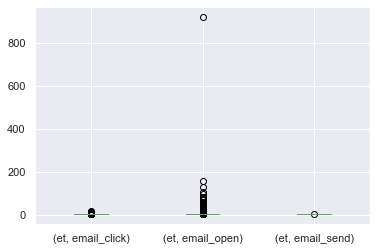

In [9]:
#boxplot indicates outlier in email open event
e_tmp1= email_data.rename(columns={'event_time':'et'})
e_tmp1.groupby(['id','event_type']).count().unstack().boxplot()

In [10]:
#check dataframe for id
e_tmp1[e_tmp1['event_type'] == 'email_open'].groupby(['id']).size().sort_values(ascending=False).head(10)

id
b4fe117c-c124-4445-a847-0fca26398002    920
b83c803f-834b-4b34-a667-ef54ae540284    158
09d14f6f-c76c-4628-9f52-d6bbcab154b1    128
97a99387-53c8-42c3-a9c1-7b221652fd53    106
e3e3c186-f9b8-496c-8d3e-4da63b3f8f3b     94
3e1da7f9-0f45-4784-8623-9edb43a49996     84
3f4d8d21-6c93-451a-901d-3f4f14d8df2f     82
a0d0c52d-477c-4148-acc6-17f2dd4e5332     71
02662626-33e1-498c-bf1f-a5533f234bbe     69
642cddbb-0f88-4c7d-8489-fc6b27dfb759     58
dtype: int64

In [11]:
#id opened email 920 times without clicking? 
display(e_tmp1[e_tmp1.id == 'b4fe117c-c124-4445-a847-0fca26398002']['event_type'].value_counts())
#check if other high openers clicked
e_tmp2 = e_tmp1.groupby(['id','event_type']).size().unstack().dropna()
e_tmp2 = e_tmp2.reset_index()
e_tmp2.set_index("id")["email_open"].sort_values(ascending=False).head()

email_open    920
email_send      1
Name: event_type, dtype: int64

id
b83c803f-834b-4b34-a667-ef54ae540284    158.0
97a99387-53c8-42c3-a9c1-7b221652fd53    106.0
3e1da7f9-0f45-4784-8623-9edb43a49996     84.0
3f4d8d21-6c93-451a-901d-3f4f14d8df2f     82.0
a0d0c52d-477c-4148-acc6-17f2dd4e5332     71.0
Name: email_open, dtype: float64

With an email open rate of 24.8% and click rate of 2.7% the Click to Open Rate is 10.9%

In [12]:
e_tmp.head()
rates = email_data.groupby('event_type')['id'].unique().apply(lambda x: x.size)
rates = 100 * rates / rates.max()
display(rates.head())
print(f'CTOR = {rates[0]/rates[1]:.2%}')
#####comeback for this include COTR, CTR,EMail open rate

event_type
email_click      2.703435
email_open      24.795286
email_send     100.000000
Name: id, dtype: float64

CTOR = 10.90%


In [13]:
####ORDERS
#snapshot of Orders data
display(orders.describe())
display(orders.head())


revenue
count  44193.000000
mean      73.303170
std       80.512492
min        0.000000
25%       17.000000
50%       30.000000
75%      160.000000
max     1140.000000

product   event_type          event_time  \
0  trinket  promo_order 2017-04-22 00:00:31   
1    gizmo  promo_order 2017-04-22 00:07:19   
2  trinket  promo_order 2017-04-22 00:10:43   
3    other  promo_order 2017-04-22 00:17:47   
4    other  promo_order 2017-04-22 00:35:32   

                                     id  revenue  
0  1fd28d09-3636-46a1-960a-351dac621e87       15  
1  858754f9-da05-4c2a-ac98-eadc27bcbe81       28  
2  c0bb1769-78f0-488b-95db-73cc1c50f07e       17  
3  f70496a6-5819-4825-ae23-a49e508c53f8       40  
4  acaea947-b67c-48c2-aca5-7d265394418d       27

In [14]:
print(orders['product'].unique())
print(orders["event_type"].unique())


['trinket' 'gizmo' 'other' 'widget']
['promo_order']


In [15]:
#count of duplicate order entries= 147
orders.shape[0]-orders.drop_duplicates().shape[0]

147

In [16]:
orders.drop_duplicates(inplace=True)

The bar chart below shows the percentage of products ordered within the "orders" file. 

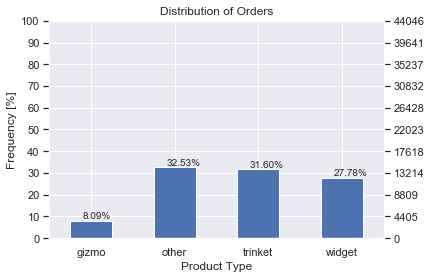

In [17]:
ax = (orders['product'].value_counts()/len(orders)*100).sort_index().plot(kind="bar", rot=0)
ax.set_yticks(np.arange(0, 110, 10))
plt.title('Distribution of Orders')
plt.xlabel('Product Type')
plt.ylabel('Frequency [%]')
ax.set_yticks(np.arange(0, 110, 10))
ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(orders)/100)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

ax2.grid(None)

In [18]:
#del e_tmp,e_tmp1, e_tmp2
o_tmp = orders.groupby(['event_time','product']).sum().unstack()
#o_tmp.describe()
#o_tmp.head()

The stacked line plots below trace the quantity of orders and revenue by product across the campaign period. The email
campaign began on the evening of the 25th, where orders seem to rise for all products except widgets. 



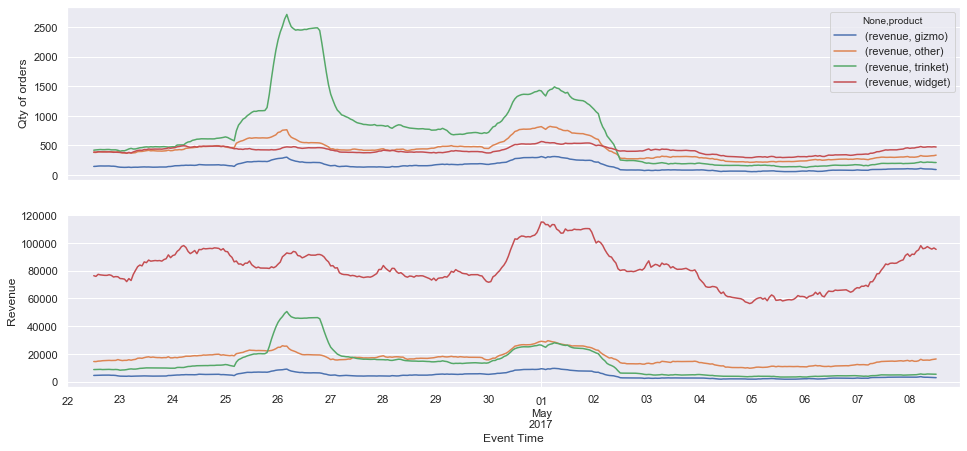

In [19]:
###Apparent bump in orders within the first few days of the campaign. Widgets revenue/orders seem inelastic

#plot orders against revenues
fig,ax = plt.subplots(2,1,figsize=(16,7))
#Attempt smoothing over 24 hours
#ord_ = o_tmp.resample('24H').count()
ord_ = o_tmp[:'2017-05-08'].resample('1H').count().rolling(24, center=True).sum()
ord_.plot(ax =ax[0])
ax[0].set_ylabel('Qty of orders')
ax[0].axes.get_xaxis().set_visible(False)
#smooth results and zoom in on tighter window
ord_ = o_tmp[:'2017-05-08'].resample('1H').sum().rolling(24,center=True).sum()
ord_.plot(ax=ax[1])
ax[1].set_ylabel('Revenue')
ax[1].set_xlabel('Event Time')
ax[1].legend_.remove()

Within the sample, more orders occur during mid-day and on weekends. The top plot shows orders across hours of the day,
while the bottom shows orders by day of week.

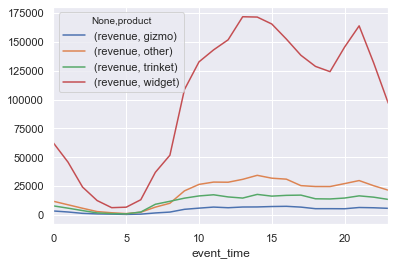

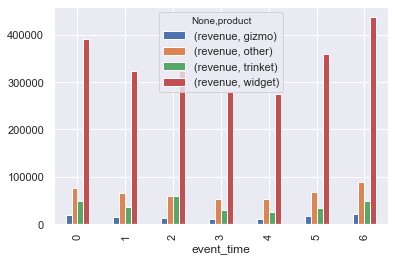

In [20]:
#evaluate orders by time of day and day of week.
#peak orders occur mid-day on the weekend
o_tmp.groupby(o_tmp.index.hour).sum().plot()
o_tmp.groupby(o_tmp.index.weekday).sum().plot.bar()
 

Revenue shows a higher spread for the 'other' product category and a higher midpoint for widgets. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f179898>,
      dtype=object)

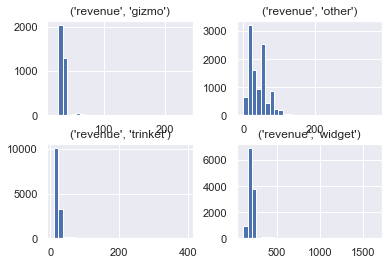

In [21]:
#distributon of revenue across product orders
o_tmp.hist(bins=30)

id
b57623f8-4b4d-4108-ada0-a4e5cade3a2f    2085
86113d05-3d8e-4ecc-a96a-38733f80d93a    1858
8fd579bb-2c46-47ba-a9bc-da9920e84a14    1714
ea2cfbe3-954f-4d91-80e4-bccfc3ca92bc    1688
8e625ea9-8783-490c-ac42-872599429c93    1684
Name: revenue, dtype: int64

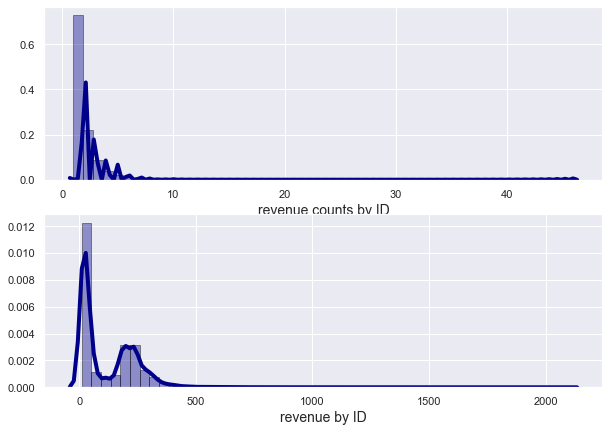

In [22]:

fig,ax = plt.subplots(2,1,figsize=(10,7))
ord_by_id = orders.groupby('id')['revenue'].count()
#ord_by_id.shape
o_bid= sns.distplot(ord_by_id, hist=True, kde=True, 
             bins=int(50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},label="orders by id",ax=ax[0])
o_bid.set_xlabel("revenue counts by ID", {'size':'14'})
ord_by_id.sort_values(ascending=False).head()

rev_by_id = orders.groupby('id')['revenue'].sum()
rev_bid= sns.distplot(rev_by_id, hist=True, kde=True, 
             bins=int(50), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},label="orders by id",ax=ax[1])
rev_bid.set_xlabel("revenue by ID", {'size':'14'})
rev_by_id.sort_values(ascending=False).head()

In [23]:
####PARAMS
display(params.describe(include="all"))
display(params.head())
params.shape[0]-params.drop_duplicates().shape[0]

id has_purchased_widget  \
count                                1307992               512207   
unique                               1307992                    2   
top     d60a36ea-d013-4454-8b11-dac14121aaa8                    t   
freq                                       1               405617   
first                                    NaN                  NaN   
last                                     NaN                  NaN   
mean                                     NaN                  NaN   
std                                      NaN                  NaN   
min                                      NaN                  NaN   
25%                                      NaN                  NaN   
50%                                      NaN                  NaN   
75%                                      NaN                  NaN   
max                                      NaN                  NaN   

       has_purchased_trinket has_purchased_gizmo    order_count  \
count                 512207              512207  512207.000000   
unique                     2                   2            NaN   
top                        f                   f            NaN   
freq                  359310              461688            NaN   
first                    NaN                 NaN            NaN   
last                     NaN                 NaN            NaN   
mean                     NaN                 NaN       1.193336   
std                      NaN                 NaN       1.932172   
min                      NaN                 NaN       1.000000   
25%                      NaN                 NaN       1.000000   
50%                      NaN                 NaN       1.000000   
75%                      NaN                 NaN       1.000000   
max                      NaN                 NaN     799.000000   

           first_order_date      last_order_date  lifetime_revenue  
count                512207               512207      5.121160e+05  
unique                 1200                 1200               NaN  
top     2017-04-26 00:00:00  2017-04-26 00:00:00               NaN  
freq                   2518                 2932               NaN  
first   2014-04-22 00:00:00  2014-04-22 00:00:00               NaN  
last    2017-08-03 00:00:00  2017-08-03 00:00:00               NaN  
mean                    NaN                  NaN      1.708133e+04  
std                     NaN                  NaN      1.293264e+04  
min                     NaN                  NaN      4.000000e+02  
25%                     NaN                  NaN      1.240000e+04  
50%                     NaN                  NaN      1.700000e+04  
75%                     NaN                  NaN      2.000000e+04  
max                     NaN                  NaN      3.552371e+06

id has_purchased_widget  \
0  b559a1d3-5599-4223-92fb-f68d35f8bcb8                    f   
1  fcd46843-a4a3-4c7b-bd89-14847303f566                  NaN   
2  05017c37-180b-4122-a528-0f5c78fc1010                  NaN   
3  5b41894b-52da-4269-9502-1b9eb0974193                  NaN   
4  2f74bc5c-c1c5-4a7a-a04d-e594d989a5ea                  NaN   

  has_purchased_trinket has_purchased_gizmo  order_count first_order_date  \
0                     t                   f          1.0       2017-01-23   
1                   NaN                 NaN          NaN              NaT   
2                   NaN                 NaN          NaN              NaT   
3                   NaN                 NaN          NaN              NaT   
4                   NaN                 NaN          NaN              NaT   

  last_order_date  lifetime_revenue  
0      2017-01-23            1700.0  
1             NaT               NaN  
2             NaT               NaN  
3             NaT               NaN  
4             NaT               NaN

0

In [24]:
print(len(params["id"].unique()))
params.has_purchased_gizmo.unique(), params.has_purchased_trinket.unique(), params.has_purchased_widget.unique()


1307992


(array(['f', nan, 't'], dtype=object),
 array(['t', nan, 'f'], dtype=object),
 array(['f', nan, 't'], dtype=object))

574710     799.0
1189079    560.0
601706     498.0
469602     405.0
279362     397.0
994500     222.0
857040     167.0
1070788    160.0
1210014    128.0
905940     108.0
Name: order_count, dtype: float64 994500     3552371.0
574710     2183417.0
294348     1181200.0
1221882    1040300.0
963529      837900.0
393494      760400.0
771080      654500.0
853112      640600.0
469602      621600.0
285990      590000.0
Name: lifetime_revenue, dtype: float64


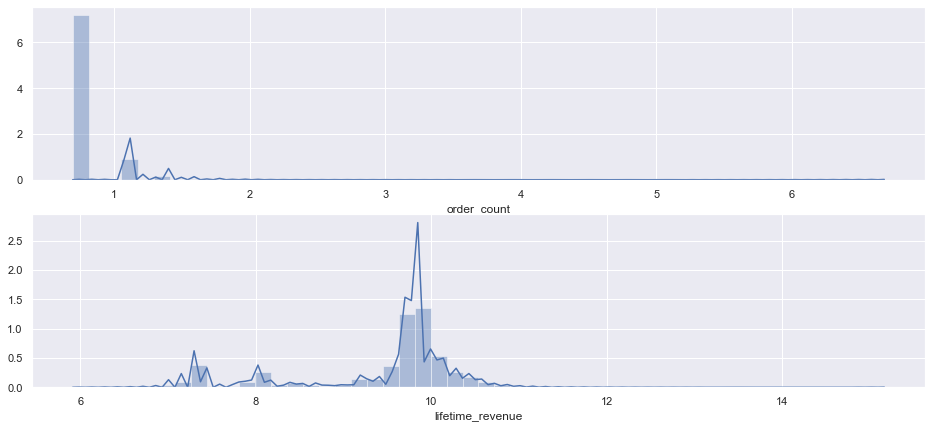

In [25]:
### Values are taken as ln(x+1). Shows distribution across "paramers" data.
fig,ax = plt.subplots(2,1,figsize=(16,7))
sns.distplot(np.log1p(params['order_count'].dropna()), ax=ax[0])
sns.distplot(np.log1p(params['lifetime_revenue'].dropna()), ax=ax[1])
print(params['order_count'].sort_values( ascending=False).head(10),
      params['lifetime_revenue'].sort_values( ascending=False).head(10))


/Users/brjax/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.
/Users/brjax/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


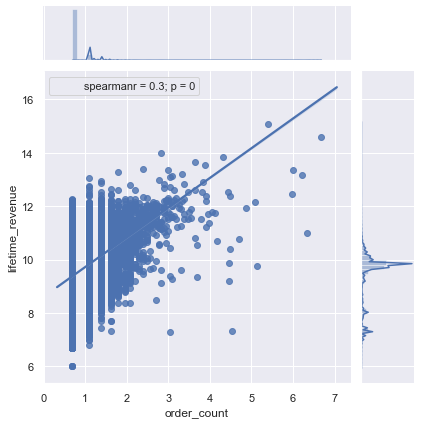

In [26]:
j= sns.jointplot(x=np.log1p(params.order_count), y=np.log1p(params.lifetime_revenue), kind='reg')
j.annotate(stats.spearmanr)

The lattice below provides a description for each bin of purchase combinations observed in the data sample. 

In [27]:
params.groupby(['has_purchased_widget', 'has_purchased_trinket', 'has_purchased_gizmo'])[['lifetime_revenue', 
                                                                                          'order_count']].describe()

lifetime_revenue  \
                                                                          count   
has_purchased_widget has_purchased_trinket has_purchased_gizmo                    
f                    f                     f                            18098.0   
                                           t                             7275.0   
                     t                     f                            75197.0   
                                           t                             5929.0   
t                    f                     f                           321486.0   
                                           t                            12360.0   
                     t                     f                            46816.0   
                                           t                            24955.0   

                                                                              \
                                                                        mean   
has_purchased_widget has_purchased_trinket has_purchased_gizmo                 
f                    f                     f                     4046.479114   
                                           t                     4542.459519   
                     t                     f                     2283.537801   
                                           t                     8012.683420   
t                    f                     f                    19312.618525   
                                           t                    25548.836731   
                     t                     f                    23032.989961   
                                           t                    32830.577520   

                                                                              \
                                                                         std   
has_purchased_widget has_purchased_trinket has_purchased_gizmo                 
f                    f                     f                     2142.253295   
                                           t                     3036.114410   
                     t                     f                     1504.414615   
                                           t                     5245.600073   
t                    f                     f                     7329.542876   
                                           t                    10523.974669   
                     t                     f                    11053.936323   
                                           t                    34267.146452   

                                                                        \
                                                                   min   
has_purchased_widget has_purchased_trinket has_purchased_gizmo           
f                    f                     f                     400.0   
                                           t                     800.0   
                     t                     f                    1064.0   
                                           t                    1700.0   
t                    f                     f                    6241.0   
                                           t                    8110.0   
                     t                     f                    8286.0   
                                           t                    9792.0   

                                                                         \
                                                                    25%   
has_purchased_widget has_purchased_trinket has_purchased_gizmo            
f                    f                     f                     2589.0   
                                           t                     2800.0   
                     t                     f                     1500.0   
                                           t                     4900.0   
t                    f                     f   

The plot below shows the distribution of time between the first and last order. Most customers appear to be one time
buyers.


count    512207.000000
mean         26.760421
std         105.798043
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1193.000000
dtype: float64

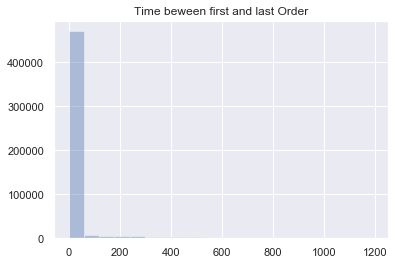

In [28]:
#show distribution of time between first and last order/first time buyers
t_btwn= (params['last_order_date'] - params['first_order_date']).dropna().apply(lambda x: x.days)
sns.distplot(t_btwn, bins=20,kde=False)
plt.title('Time beween first and last Order')
t_btwn.describe()

In [29]:
##### EVALUATE CAMPAIGN SUCCESS
    
full = params[(params.order_count >= 1) & (params.first_order_date < '2017-04-25 19:00:51')]
reduced =params[(params.order_count >= 1) & (params.last_order_date > '2016-04') & (params.first_order_date < '2017-04-25 19:00:51')]
print(f'full :{full.shape[0]}\n' f'campaign date - 1Y: {reduced.shape[0]}')
# order_before.shape
display(full.describe())
display(reduced.describe())



full :449447
campaign date - 1Y: 290981


order_count  lifetime_revenue
count  449447.000000      4.493560e+05
mean        1.202324      1.720036e+04
std         2.055388      1.292944e+04
min         1.000000      4.000000e+02
25%         1.000000      1.482000e+04
50%         1.000000      1.700000e+04
75%         1.000000      1.900000e+04
max       799.000000      3.552371e+06

order_count  lifetime_revenue
count  290981.000000      2.909550e+05
mean        1.277018      1.699927e+04
std         2.518248      1.533663e+04
min         1.000000      4.000000e+02
25%         1.000000      8.177000e+03
50%         1.000000      1.700000e+04
75%         1.000000      2.200000e+04
max       799.000000      3.552371e+06

The customers need to be split into control and treatment groups to benchmark the performance of the campaign. Only 
customers who have purchased something in the last year and whose first purchase precede the start of the campaign are 
considered. It is worth mentioning that the percentiles and moments of the distributions are similar between the full 
'parameters' dataset and that of the dataset reduced to the last year. Customers who received and opened the email 
comprise the treatment group while those that did not receive email comprise the control. 

The product purchase lattice history was recreated for each the control and treatment group to confirm similar 
proportions of purchased items. The percentage point difference between each bin of product combinations is shown below; 
the difference is small (<|4%|). 

The stacked charts below display the orders for each group scaled by their respective group sizes. The treatment group 
shows higher orders across all products. However, there is a rise in orders leading up to the campaign. It is unclear 
if there was a promotion applied in the preceding week or seasonal purchase effect for the products in scope. For 
widgets, there is a clear drop in orders in the control group around the beginning of the campaign. The cause is 
unclear though given the assumed higher price point (based on the higher per item revenue) of widgets and the increased 
sales immediately preceding the campaign, this may correspond to a durable good purchase with many buyers having met 
their consumption needs of said good prior to campaign initiation. 

note: The analysis will not deal with increasing clicks from email opens as no data was given on the email.

In [30]:
###split into treatment and control groups.
#filter IDs for customers that made a purchase in the past year 
filter_ids= params[(params.order_count >= 1) & (params.last_order_date > '2016-04') &\
                   (params.first_order_date < '2017-04-25 19:00:51')]['id'].unique()
#create treatment and control id filter
treatment_ids = email_data[(email_data.event_type == 'email_open') & (email_data.id.isin(filter_ids))]['id'].unique()
control_ids = np.array(list(set(filter_ids)-set(treatment_ids)))

#check the distribution of the treatment group
#params[(params.id.isin(control_ids))].describe()

###compare distribution of purchase history between control and treatment 
tmpc = params[(params.id.isin(control_ids))].groupby(['has_purchased_widget', 'has_purchased_trinket', \
                                                      'has_purchased_gizmo'])['order_count'].describe()
display(tmpc)
tmpc1 = np.array(tmpc[['count']])
tmpc2 = tmpc1/tmpc1.sum()
#print(tmpc2, tmpc2.sum())

tmpt = params[(params.id.isin(treatment_ids))].groupby(['has_purchased_widget', 'has_purchased_trinket',\
                                                        'has_purchased_gizmo'])['order_count'].describe()
display(tmpt)
tmpt1 = np.array(tmpt[['count']])
tmpt2 = tmpt1/tmpt1.sum()
#print(tmpt2, tmpt2.sum())

#print diffrence in relative counts of each lattice point across the has purchased dimension. 
pd.DataFrame(tmpc2-tmpt2).applymap(lambda x: '{:.2%}'.format(x)).values
#Treatment group consists of customers with at least two orders in the past. Filter changed to orders>1
# print(len(treatment_ids))
# print(len(control_ids))
  

count  \
has_purchased_widget has_purchased_trinket has_purchased_gizmo             
f                    f                     f                     11340.0   
                                           t                      4276.0   
                     t                     f                     44567.0   
                                           t                      3528.0   
t                    f                     f                    127189.0   
                                           t                      7639.0   
                     t                     f                     27995.0   
                                           t                     14352.0   

                                                                    mean  \
has_purchased_widget has_purchased_trinket has_purchased_gizmo             
f                    f                     f                    1.069312   
                                           t                    1.158793   
                     t                     f                    1.126237   
                                           t                    1.761621   
t                    f                     f                    1.114672   
                                           t                    1.464328   
                     t                     f                    1.594606   
                                           t                    2.032191   

                                                                     std  min  \
has_purchased_widget has_purchased_trinket has_purchased_gizmo                  
f                    f                     f                    0.862825  1.0   
                                           t                    0.482484  1.0   
                     t                     f                    0.393759  1.0   
                                           t                    1.232133  1.0   
t                    f                     f                    1.633582  1.0   
                                           t                    0.726381  1.0   
                     t                     f                    0.921553  1.0   
                                           t                    9.080632  1.0   

                                                                25%  50%  75%  \
has_purchased_widget has_purchased_trinket has_purchased_gizmo                  
f                    f                     f                    1.0  1.0  1.0   
                                           t                    1.0  1.0  1.0   
                     t                     f                    1.0  1.0  1.0   
                                           t                    1.0  1.0  2.0   
t                    f                     f                    1.0  1.0  1.0   
                                           t                    1.0  1.0  2.0   
                     t                     f                    1.0  1.0  2.0   
                                           t                    1.0  1.0  2.0   

                                                                  max  
has_purchased_widget has_purchased_trinket has_purchased_gizmo         
f                    f                     f                     85.0  
                                           t                     12.0  
                     t                     f                      7.0  
                                           t                     39.0  
t                    f                     f                    560.0  
                                           t                      9.0  
                     t                     f                     56.0  
                                           t                    799.0

count  \
has_purchased_widget has_purchased_trinket has_purchased_gizmo            
f                    f                     f                     2559.0   
                                           t                      755.0   
                     t                     f                     7501.0   
                                           t                      945.0   
t                    f                     f                    25221.0   
                                           t                     1837.0   
                     t                     f                     7151.0   
                                           t                     4126.0   

                                                                    mean  \
has_purchased_widget has_purchased_trinket has_purchased_gizmo             
f                    f                     f                    1.076592   
                                           t                    1.300662   
                     t                     f                    1.269564   
                                           t                    2.183069   
t                    f                     f                    1.146663   
                                           t                    1.701688   
                     t                     f                    1.858481   
                                           t                    2.586767   

                                                                     std  min  \
has_purchased_widget has_purchased_trinket has_purchased_gizmo                  
f                    f                     f                    0.289906  1.0   
                                           t                    0.631563  1.0   
                     t                     f                    1.210121  1.0   
                                           t                    2.510007  1.0   
t                    f                     f                    0.442512  1.0   
                                           t                    0.972533  1.0   
                     t                     f                    1.230656  1.0   
                                           t                    7.133301  1.0   

                                                                25%  50%  75%  \
has_purchased_widget has_purchased_trinket has_purchased_gizmo                  
f                    f                     f                    1.0  1.0  1.0   
                                           t                    1.0  1.0  1.0   
                     t                     f                    1.0  1.0  1.0   
                                           t                    1.0  2.0  3.0   
t                    f                     f                    1.0  1.0  1.0   
                                           t                    1.0  1.0  2.0   
                     t                     f                    1.0  2.0  2.0   
                                           t                    1.0  2.0  3.0   

                                                                  max  
has_purchased_widget has_purchased_trinket has_purchased_gizmo         
f                    f                     f                      4.0  
                                           t                      7.0  
                     t                     f                     93.0  
                                           t                     61.0  
t                    f                     f                     11.0  
                                           t                     10.0  
                     t                     f                     64.0  
                                           t                    397.0

array([['-0.40%'],
       ['0.27%'],
       ['3.53%'],
       ['-0.42%'],
       ['2.45%'],
       ['-0.50%'],
       ['-2.65%'],
       ['-2.28%']], dtype=object)

In [31]:
#Sammple is sufficiently large.
tt_ind_solve_power(effect_size=0.1, nobs1 = None, alpha=0.05, power=0.8, ratio=(len(control_ids)/len(treatment_ids)), \
                   alternative='two-sided')  

948.4428841823567

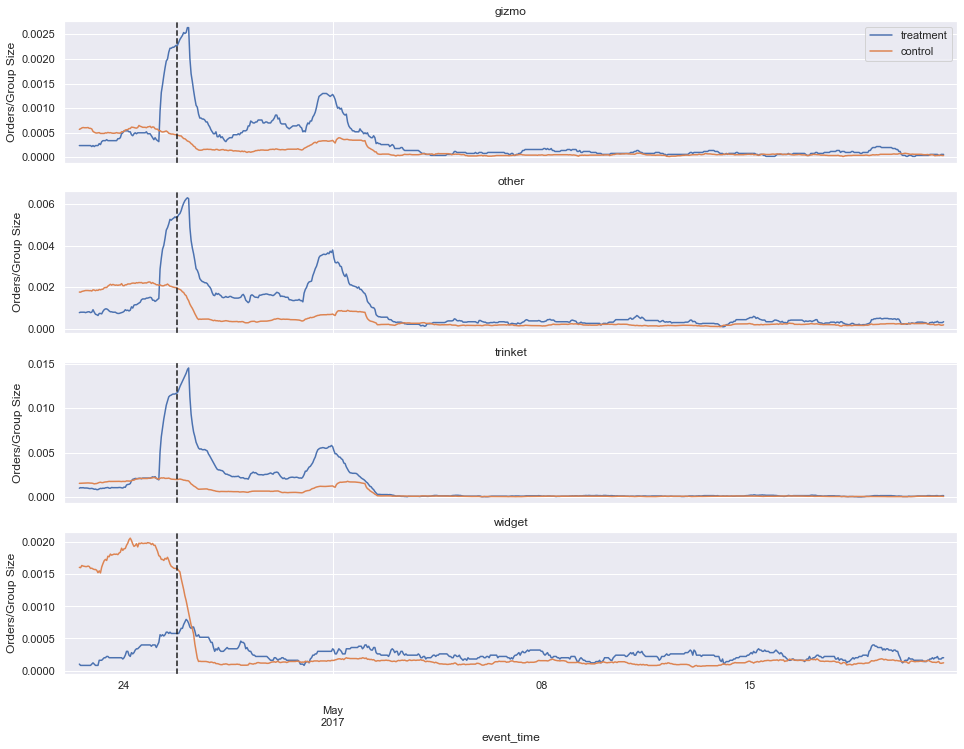

In [32]:
tr_tmp = orders[(orders.id.isin(treatment_ids))].groupby(["event_time","product"]).size().unstack()
ctr_tmp = orders[(orders.id.isin(control_ids))].groupby(["event_time","product"]).size().unstack()

#ctr_tmp.head()

fig, axes = plt.subplots(4,1,figsize=(16,12), sharex=True)
tc_col = ['gizmo', 'other', 'trinket', 'widget']
for ax, col in zip(axes,tc_col):
    tr_tmp[col].resample('1H').sum().rolling(24, center=True).sum().divide(treatment_ids.size).plot(ax=ax, label='treatment')
    ctr_tmp[col].resample('1H').sum().rolling(24, center=True).sum().divide(control_ids.size).plot(ax=ax, label='control')
    ax.set_title(col)
    ax.axvline(email_data["event_time"].min(), color='k', linestyle='--')
    ax.set_ylabel('Orders/Group Size')
    if ax == axes[0]:
        ax.legend()
        

product
gizmo      0.007346
other      0.021459
trinket    0.028087
widget     0.006587
Name: id, dtype: float64

product
gizmo      0.002478
other      0.007701
trinket    0.008539
widget     0.003894
Name: id, dtype: float64

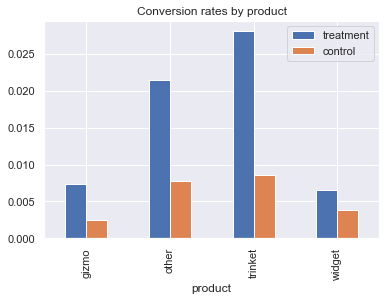

In [33]:
tr_tmp = orders[(orders.id.isin(treatment_ids)) & (orders.event_time > '2017-04-25 19:00:51')].groupby('product')\
             ['id'].count()/ treatment_ids.size
ctr_tmp = orders[(orders.id.isin(control_ids)) & (orders.event_time > '2017-04-25 19:00:51')].groupby('product')\
              ['id'].count()/ control_ids.size
pd.DataFrame({'treatment':tr_tmp, 'control':ctr_tmp}).plot.bar()
plt.title('Conversion rates by product')
display(tr_tmp.head())
display(ctr_tmp.head())

The conversion rate, corresponding to the sales during the campaign period within each respective split group, is 
reported by repeated sampling from the beta distribution. By simulating variations, a confidence interval can be 
produced around the conversion rate. The mean conversion rate within the control and treatment group 
respectively are implying an uplift of around 193%. 

In [34]:
tr_cv = orders[(orders.id.isin(treatment_ids)) & (orders.event_time > '2017-04-25 19:00:51')]['id'].unique().size#/ treatment_ids.size
ctr_cv = orders[(orders.id.isin(control_ids)) & (orders.event_time > '2017-04-25 19:00:51')]['id'].unique().size#/ control_ids.size
print(f'treatment conversion {tr_cv/treatment_ids.size:.2%}\n'
      f'control conversion {ctr_cv/control_ids.size:.2%}\n'
      f'Uplift {((tr_cv/ctr_cv)-1):.2%}'
)

treatment conversion 4.46%
control conversion 1.52%
Uplift -38.98%


In [35]:
#Return beta estimation of conversion rates
# from scipy.stats import beta
# tr_beta= beta(tr_cv,(treatment_ids.size-tr_cv))
# ctr_beta = beta(ctr_cv,(control_ids.size-tr_cv))
# fig, ax = plt.subplots(figsize=(8, 6))
# x = np.linspace(0.05, 0.2, 1000) 
# ax.plot(x, tr_beta.pdf(x))
# ax.plot(x, ctr_beta.pdf(x))
# ax.set(xlabel='conversion rate', ylabel='density')
#numpy faster than scipy
tr_beta = []
ctr_beta =[]
for _ in range(1000000):
    tr_beta.append(np.random.beta(tr_cv, (treatment_ids.size-tr_cv)))
    ctr_beta.append(np.random.beta(ctr_cv, (control_ids.size-ctr_cv)))

print('Confidence intervals for conversion rates\n'
      f'Treatmemt: lower = {np.quantile(tr_beta,0.025)}\tupper={np.quantile(tr_beta,0.975)}\n'
      f'Control: lower = {np.quantile(ctr_beta,0.025)}\tupper={np.quantile(ctr_beta,0.975)}'
      )

Confidence intervals for conversion rates
Treatmemt: lower = 0.042767609826640705	upper=0.046383317453124316
Control: lower = 0.014701288059460447	upper=0.015679735134803183


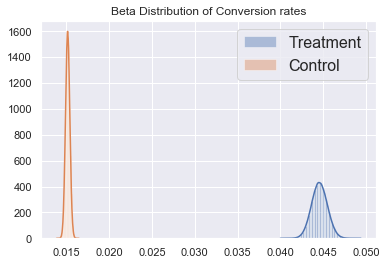

In [36]:
##plot distribution of conversion rates
fig, ax = plt.subplots()
sns.distplot(tr_beta, ax=ax, label = "Treatment")
sns.distplot(ctr_beta, ax=ax, label= "Control")
plt.title('Beta Distribution of Conversion rates')
plt.legend(prop={'size': 16})

In [37]:
tr_cv = orders[(orders.id.isin(treatment_ids)) & (orders.event_time > '2017-04-25 19:00:51')].groupby('product')['id'].unique()
ctr_cv = orders[(orders.id.isin(control_ids)) & (orders.event_time > '2017-04-25 19:00:51')].groupby('product')['id'].unique()
ts=treatment_ids.size
cs=control_ids.size
for i,c in enumerate(['gizmo', 'other', 'trinket', 'widget']):
    print(f'Uplift for {c}: {(tr_cv[i].size/ts)/(ctr_cv[i].size/cs)-1:.2%}')

Uplift for gizmo: 196.83%
Uplift for other: 177.33%
Uplift for trinket: 221.01%
Uplift for widget: 71.93%


In [38]:
#Student  T-Test for revenue
# from scipy import stats
# stats.ttest_ind(orders[orders.id.isin(treatment_ids)]['revenue'],orders[orders.id.isin(control_ids)]['revenue'])



In [39]:
##per unit revenue is higher for widgets
(orders.groupby('product')['revenue'].sum()/orders.groupby('product')['revenue'].count()).head()
#orders.groupby('product')['revenue'].count().head()

product
gizmo       30.203537
other       32.235692
trinket     20.069407
widget     195.005802
Name: revenue, dtype: float64

In [40]:
#prep dataset for uplift modeling
prep = params.dropna(subset=['has_purchased_widget', 'has_purchased_trinket',
               'has_purchased_gizmo', 'order_count', 'first_order_date',
               'last_order_date', 'lifetime_revenue'])

prep = prep[(prep.id.isin(filter_ids))]
#keep dates up until the end of campaign
prep = prep[(prep.last_order_date > '2016-04')& (prep.last_order_date < '2017-05-22')]
prep['Treatment'] = 0
prep['Treatment'][prep.id.isin(treatment_ids)] = 1
prep[['has_purchased_widget', 'has_purchased_trinket','has_purchased_gizmo']]=\
    prep[['has_purchased_widget', 'has_purchased_trinket','has_purchased_gizmo']].applymap(lambda x: 1 if x == 't' else 0) 

prep['days_since_last_order'] = (prep.last_order_date.max() - prep.last_order_date).apply(lambda x: x.days)
prep['days_since_first_order'] = (prep.last_order_date.max() - prep.first_order_date).apply(lambda x: x.days)
prep['Outcome'] = 0
prep['Outcome'][(prep.id.isin(orders[(orders.event_time > '2016-04')]['id'].unique()))] = 1
prep.drop(columns=['last_order_date', 'first_order_date','id'], inplace=True)
prep.head()

/Users/brjax/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/brjax/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


has_purchased_widget  has_purchased_trinket  has_purchased_gizmo  \
0                      0                      1                    0   
10                     1                      0                    0   
12                     1                      0                    0   
13                     1                      0                    0   
14                     1                      0                    0   

    order_count  lifetime_revenue  Treatment  days_since_last_order  \
0           1.0            1700.0          0                    118   
10          1.0           17000.0          0                    254   
12          1.0           17000.0          0                    248   
13          1.0           17000.0          1                    283   
14          1.0           29000.0          0                     75   

    days_since_first_order  Outcome  
0                      118        0  
10                     254        0  
12                     248        0  
13                     283        0  
14                      75        0

In [41]:
pd.crosstab(prep['Outcome'],prep['Treatment'])


Treatment       0      1
Outcome                 
0          228162  45408
1            6598   2841

In [42]:
#prep.describe()
prep.isnull().sum()

has_purchased_widget      0
has_purchased_trinket     0
has_purchased_gizmo       0
order_count               0
lifetime_revenue          0
Treatment                 0
days_since_last_order     0
days_since_first_order    0
Outcome                   0
dtype: int64

In [43]:
###scale the data prior to modeling
from sklearn.preprocessing import MinMaxScaler
#train test split
train_df, test_df = train_test_split(prep, test_size=0.2, random_state=2731, stratify=prep['Treatment'])

sc = MinMaxScaler()
train_df = pd.DataFrame(sc.fit_transform(train_df), columns = train_df.columns) 
test_df = pd.DataFrame(sc.transform (test_df), columns = test_df.columns)



 
Uplifting Modeling: 
The following provides results from propensity scoring and uplift modeling. The propensity scores measure the 
conditional probabilities to convert with and without treatment, whereas uplift measures lift. The uplift model uses 
xgboost and the propensity model uses logistic regression. The data imbalances are handled by weighting the 
underrepresented class more heavily through the parameter settings of each model. 



[Estimate propensity scores for Inverse Probability Weighting.]
[2019-11-17 17:59:21,356|causallift.context.flexible_context|INFO] Run pipeline (tags: ['011_bundle_train_and_test_data'], SequentialRunner, only_missing: False)
[2019-11-17 17:59:21,373|kedro.pipeline.node|INFO] Running node: bundle_train_and_test_data([args_raw,test_df,train_df]) -> [df_00]
[2019-11-17 17:59:21,450|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2019-11-17 17:59:21,453|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-17 17:59:21,469|causallift.context.flexible_context|INFO] Run pipeline (tags: ['121_prepare_args', '131_treatment_fractions_', '141_initialize_model'], SequentialRunner, only_missing: False)
[2019-11-17 17:59:21,484|kedro.pipeline.node|INFO] Running node: impute_cols_features([args_raw,df_00]) -> [args_intermediate]
[2019-11-17 17:59:21,488|kedro.runner.sequential_runner|INFO] Completed 1 out of 3 tasks
[2019-11-17 17:59:21,492|kedro.

has_purchased_widget  has_purchased_trinket  has_purchased_gizmo  \
coefficient              0.066303               0.012891              0.11334   

             order_count  lifetime_revenue  days_since_last_order  \
coefficient    34.131419         17.290638              -0.588738   

             days_since_first_order  
coefficient                0.731084

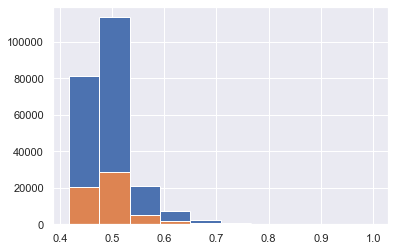

# samples  # classes  accuracy  precision    recall        f1  \
train     226407          2  0.611721   0.204674  0.442680  0.279924   
test       56602          2  0.606639   0.198191  0.429223  0.271171   

        roc_auc  observed conversion rate  predicted conversion rate  
train  0.544572                  0.170485                   0.368734  
test   0.536163                  0.170489                   0.369227

Pred_0  Pred_1
True_0  121411   66397
True_1   21512   17087

Pred_0  Pred_1
True_0   30195   16757
True_1    5508    4142

In [44]:
#define model params--class weight set to balanced for weighting of class imbalances

p_dict_xg=dict(
    search_cv="sklearn.model_selection.GridSearchCV",
    estimator="xgboost.XGBClassifier",
    scoring=None,
    cv=3,
    return_train_score=False,
    n_jobs=-1,
    param_grid=dict(
        max_depth=[3],
        learning_rate=[0.1],
        n_estimators=[100],
        verbose=[0],
        objective=["binary:logistic"],
        booster=["gbtree"],
        n_jobs=[-1],
        nthread=[None],
        gamma=[0],
        min_child_weight=[1],
        max_delta_step=[0],
        subsample=[1],
        colsample_bytree=[1],
        colsample_bylevel=[1],
        reg_alpha=[0],
        reg_lambda=[1],
        scale_pos_weight=[28],
        base_score=[0.5],
        missing=[None],
    ),
)

p_dict = dict(
    search_cv="sklearn.model_selection.GridSearchCV",
    estimator="sklearn.linear_model.LogisticRegression",
    scoring=None,
    cv=3,
    return_train_score=False,
    n_jobs=-1,
    param_grid=dict(
        C=[0.1, 1, 10],
        class_weight=["balanced"],
        dual=[False],
        fit_intercept=[True],
        intercept_scaling=[1],
        max_iter=[100],
        multi_class=["ovr"],
        n_jobs=[1],
        penalty=["l2"],
        solver=["liblinear"],
        tol=[0.0001],
        warm_start=[False],
    ),
)
print('\n[Estimate propensity scores for Inverse Probability Weighting.]')
cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3, uplift_model_params=p_dict_xg, \
                propensity_model_params= p_dict)

The below shows the result of two separate models, one fit to the control and one fit to the treatment. The 
difference in the predicted probability of purchase between the treatment model and the control model indicate lift.

In [45]:
print('\n[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]')
train_df, test_df = cl.estimate_cate_by_2_models()



[Create 2 models for treatment and untreatment and estimate CATE (Conditional Average Treatment Effects)]
[2019-11-17 17:59:27,290|causallift.context.flexible_context|INFO] Run pipeline (tags: ['311_fit', '312_bundle_2_models'], SequentialRunner, only_missing: False)
[2019-11-17 17:59:27,307|kedro.pipeline.node|INFO] Running node: model_for_untreated_fit([args,df_01]) -> [untreated__model_dict]
[2019-11-17 17:59:27,308|causallift.nodes.model_for_each|INFO] 

## Model for Treatment = 0.0
[2019-11-17 17:59:27,364|causallift.nodes.model_for_each|WARNING] [Warning] Propensity scores above 0.99 were clipped.
[2019-11-17 17:59:38,667|causallift.nodes.model_for_each|INFO] ### Best parameters of the model trained using samples with observational Treatment: 0.0 
 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 

/Users/brjax/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/brjax/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0        1         2         3         4         5  \
feature importance  0.003287  0.00199  0.000574  0.000851  0.001775  0.989583   

                          6  
feature importance  0.00194

# samples  # classes  accuracy  precision  recall        f1   roc_auc  \
train     187808          2  0.997295   0.912004     1.0  0.953977  0.998609   
test       46952          2  0.997487   0.918677     1.0  0.957615  0.998707   

       observed conversion rate  predicted conversion rate  
train                  0.028034                   0.030739  
test                   0.028391                   0.030904

0         1         2         3         4         5  \
feature importance  0.0  0.000154  0.000234  0.000053  0.000141  0.999189   

                           6  
feature importance  0.000229

# samples  # classes  accuracy  precision  recall        f1   roc_auc  \
train      38599          2  0.999845   0.997387     1.0  0.998692  0.999917   
test        9650          2  0.999896   0.998188     1.0  0.999093  0.999945   

       observed conversion rate  predicted conversion rate  
train                  0.059328                   0.059483  
test                   0.057098                   0.057202

In [46]:
print('\n[Estimate the effect of recommendation based on the uplift model]')
estimated_effect_df = cl.estimate_recommendation_impact()

print('\n[Show the estimated effect of recommendation based on the uplift model]')
display(estimated_effect_df)


[Estimate the effect of recommendation based on the uplift model]
[2019-11-17 17:59:42,702|causallift.context.flexible_context|INFO] Run pipeline (tags: ['511_recommend_by_cate'], SequentialRunner, only_missing: False)
[2019-11-17 17:59:42,715|kedro.pipeline.node|INFO] Running node: recommend_by_cate([args,df_02,treatment_fractions]) -> [df_03]
[2019-11-17 17:59:54,127|kedro.runner.sequential_runner|INFO] Completed 1 out of 1 tasks
[2019-11-17 17:59:54,128|kedro.runner.sequential_runner|INFO] Pipeline execution completed successfully.
[2019-11-17 17:59:54,948|causallift.context.flexible_context|INFO] Run pipeline (tags: ['521_simulate_recommendation'], SequentialRunner, only_missing: False)
[2019-11-17 17:59:55,787|kedro.pipeline.node|INFO] Running node: model_for_untreated_simulate_recommendation([args,df_03,uplift_models_dict]) -> [untreated__sim_eval_df]
[2019-11-17 17:59:56,429|causallift.nodes.model_for_each|INFO] 
### Simulated outcome of samples recommended to be treatment: 0.0

# samples  # classes  accuracy  precision  recall        f1   roc_auc  \
train     187808          2  0.999878   0.971779     1.0  0.985688  0.999939   
test       46952          2  0.999957   0.988701     1.0  0.994318  0.999979   

       observed conversion rate  predicted conversion rate  
train                  0.004217                    0.00434  
test                   0.003727                    0.00377

# samples  # classes  accuracy  precision  recall        f1   roc_auc  \
train      38599          2  0.984922   0.920762     1.0  0.958747  0.990859   
test        9650          2  0.985389   0.923784     1.0  0.960382  0.991122   

       observed conversion rate  predicted conversion rate  
train                  0.175212                    0.19029  
test                   0.177098                    0.19171

# samples chosen without uplift model  \
0                                  38599   
1                                   9650   

   observed conversion rate without uplift model  \
0                                       0.059328   
1                                       0.057098   

   # samples recommended by uplift model  \
0                                  38599   
1                                   9650   

   predicted conversion rate using uplift model  predicted improvement rate  
0                                       0.19029                    3.207424  
1                                       0.19171                    3.357532

# samples chosen without uplift model  \
0                                 187808   
1                                  46952   

   observed conversion rate without uplift model  \
0                                       0.028034   
1                                       0.028391   

   # samples recommended by uplift model  \
0                                 187808   
1                                  46952   

   predicted conversion rate using uplift model  predicted improvement rate  
0                                       0.00434                    0.154796  
1                                       0.00377                    0.132783

# samples  observed conversion rate without uplift model  \
0     226407                                       0.033369   
1      56602                                       0.033285   

   predicted conversion rate using uplift model  predicted improvement rate  
0                                      0.036041                    1.080079  
1                                      0.035811                    1.075902

In sum, beta sampling and uplift modeling suggest similarly strong lift (approximate 190%) suggesting campaign success. 
The propensity scores suggest intuitive weights were past purchases of any product correlate with a positive outcome; as 
do higher order counts, higher past revenue, and less time since the previous order. 'Time since the previous' order 
shows the highest feature importance implying customers with recent buying activity are most responsive. 
